In [3]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

custom_palette = {
    0: 'red',
    0.1: 'lightblue',
    0.5: 'lightblue',
    1: 'dodgerblue',
    2: 'royalblue',
    4: 'blue',
    16: 'navy',
    32: 'darkblue',
    64: 'midnightblue',
    'DISCREPANCY': sns.color_palette('Set2')[0],  # Default Seaborn palette color for 'DISCREPANCY'
    'ENTROPY': sns.color_palette('Set2')[1],  # Default Seaborn palette color for 'ENTROPY'
    'NegCE': sns.color_palette('Set2')[2],  # Default Seaborn palette color for 'NegCE'
    'DBAT': sns.color_palette('Set2')[3]  # Default Seaborn palette color for 'DBAT'
}

N_SAMPLES = 1000
tag = 'pac_exp'
df_path = f'dfs/{tag}.pk'

try:
    df = pd.read_pickle(df_path)
except:
    df = pd.DataFrame()

r_dfs = []
runs = wandb.Api().runs('mila-projects/domainbed', filters={'tags': tag, 'state': 'finished'})

for r in runs:
    config = r.config
    run_id = config['run_id']
    tags_str = '/'.join(r.tags)
    config['tags'] = tags_str
    if 'run_id' in df.columns and df.run_id.str.contains(run_id).any():
        continue
    r_df = r.history(samples=N_SAMPLES)
    assert r_df.step.max() == 5000
    for k, v in config.items():
        if isinstance(v, list) and len(v) > 1:
            raise Exception(k, v)
        elif isinstance(v, list):
            v = v[0]
        r_df[k] = v
    df = pd.concat([df, r_df], ignore_index=True)

df.to_pickle(df_path)
df = pd.read_pickle(df_path)

## Backfill values
df.loc[df['grad_penalty'].isna(), 'grad_penalty'] = 0.0
df['mlp_width'] = df['hparam_mlp_width']
df['mlp_depth'] = df['hparam_mlp_depth']
df['train_acc'] = (df['env1_in_acc'] + df['env2_in_acc'] + df['env3_in_acc'])/3
# df['wgan_grad_loss'] = df['grad_penalty_loss']
df.loc[df['algorithm'] == 'ERM', 'dann_disc_loss'] = ''
df['alg_name'] = df['algorithm'] + '_' + df['dann_disc_loss']
df.rename(columns={'testenv_in_acc': 'test_acc'}, inplace=True)
df = df.query('algorithm != "ERM"')

In [5]:
df.query('dann_disc_loss=="DISCREPANCY" and step==5000').groupby(['dann_disc_loss', 'grad_penalty', 'disc_params', 'dann_lambda'], as_index=False)[['test_acc']].agg(['mean', 'std']).reset_index().sort_values((      'test_acc', 'mean'), ascending=False).head(30)

dann_disc_loss grad_penalty disc_params dann_lambda  test_acc    
                                                            mean std
39    DISCREPANCY          1.0    656899.0         0.1  0.874924 NaN
21    DISCREPANCY          0.0   1575939.0         0.1  0.873703 NaN
6     DISCREPANCY          0.0    147971.0         0.1  0.871873 NaN
12    DISCREPANCY          0.0    656899.0         0.1  0.871263 NaN
33    DISCREPANCY          1.0    147971.0         0.1  0.869433 NaN
34    DISCREPANCY          1.0    147971.0         1.0  0.863331 NaN
48    DISCREPANCY          1.0   1575939.0         0.1  0.860891 NaN
0     DISCREPANCY          0.0    131331.0         0.1  0.857230 NaN
7     DISCREPANCY          0.0    147971.0         1.0  0.856010 NaN
43    DISCREPANCY          1.0    788483.0         1.0  0.854179 NaN
16    DISCREPANCY          0.0    788483.0         1.0  0.846858 NaN
18    DISCREPANCY          0.0   1050627.0         0.1  0.841367 NaN
49    DISCREPANCY          1.0   1575939.0         1.0  0.839536 NaN
25    DISCREPANCY          0.0   2101251.0         1.0  0.838926 NaN
24    DISCREPANCY          0.0   2101251.0         0.1  0.838316 NaN
26    DISCREPANCY          0.0   2101251.0         2.0  0.833435 NaN
35    DISCREPANCY          1.0    147971.0         2.0  0.832825 NaN
22    DISCREPANCY          0.0   1575939.0         1.0  0.832825 NaN
17    DISCREPANCY          0.0    788483.0         2.0  0.830384 NaN
42    DISCREPANCY          1.0    788483.0         0.1  0.826724 NaN
44    DISCREPANCY          1.0    788483.0         2.0  0.822453 NaN
51    DISCREPANCY          1.0   2101251.0         0.1  0.814521 NaN
28    DISCREPANCY          1.0    131331.0         1.0  0.813911 NaN
29    DISCREPANCY          1.0    131331.0         2.0  0.808420 NaN
13    DISCREPANCY          0.0    656899.0         1.0  0.806589 NaN
15    DISCREPANCY          0.0    788483.0         0.1  0.805979 NaN
53    DISCREPANCY          1.0   2101251.0         2.0  0.803539 NaN
40    DISCREPANCY          1.0    656899.0         1.0  0.802929 NaN
50    DISCREPANCY          1.0   1575939.0         2.0  0.802318 NaN
3     DISCREPANCY          0.0    139651.0         0.1  0.793167 NaN

In [6]:
df['run_id'].unique().shape

(178,)

In [7]:
def plot_facet_grid(df, hue, y, row=None, col=None, x='step', melt_metrics=None, palette=custom_palette, title=None, **grid_kwargs):
    if melt_metrics is not None:
        id_vars = ['step', 'dann_disc_loss', 'dann_lambda']
        if hue not in id_vars:
            id_vars.append(hue)
        df = df.melt(id_vars=id_vars, var_name='metric', value_name='value')
        df = df[df['metric'].isin(melt_metrics)]
        df['metric'] = pd.Categorical(df['metric'], melt_metrics)
        df = df.sort_values('metric')
    g = sns.FacetGrid(df, col=col, row=row, sharey=False, **grid_kwargs)
    g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, palette=palette, legend='full')
    prefix = ''
    if col == 'dann_disc_loss':
        prefix = 'loss'
    elif col == 'dann_lambda':
        prefix = 'λ'
    g.set_titles(size=10, col_template=prefix + ":{col_name}", row_template="{row_name}")
    g.add_legend(title=f'{hue}')
    if title:
        g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
        g.fig.suptitle(title)
    return g

In [16]:
base_metrics = ['train_acc', 'test_acc', 'disc_acc', 'disc_loss']
add_metrics = [
    'disc_acc_d0',
        'disc_acc_d1',
        'disc_acc_d2',
        'disc_n_preds_d0',
        'disc_n_preds_d1',
        'disc_n_preds_d2',
        'disc_prob_mean_d0',
        'disc_prob_mean_d1',
        'disc_prob_mean_d2',
        'env0_out_acc',
        'env1_out_acc',
        'env2_out_acc',
        'env3_out_acc',
        'env4_out_acc'
 ]

### Baseline Results

In [11]:
baseline_df = df[df['tags'].str.contains('pac_baseline')].query('step > 0')
baseline_df_final = baseline_df.query('step==5000')
baseline_df_final.groupby(['dann_lambda', 'dann_disc_loss'])[['test_acc', 'train_acc', 'disc_loss']].agg(['mean', 'std']).style.format_index(precision=2).format(precision=2)

<Axes: xlabel='dann_lambda', ylabel='test_acc'>

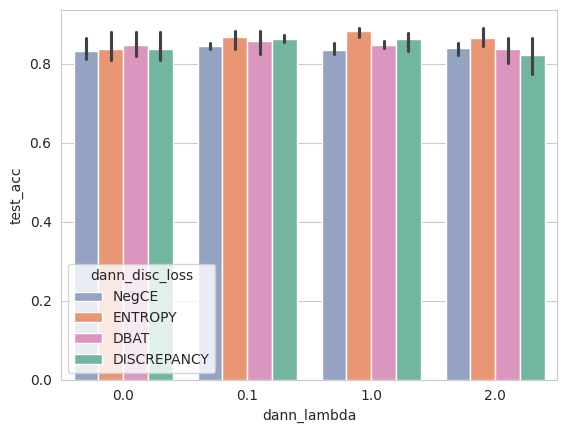

In [12]:
sns.barplot(baseline_df_final, x='dann_lambda', y='test_acc', hue='dann_disc_loss', palette=custom_palette)

In [ ]:
plot_facet_grid(baseline_df, hue='dann_lambda', y='value', row='metric', col='dann_disc_loss', melt_metrics=base_metrics)

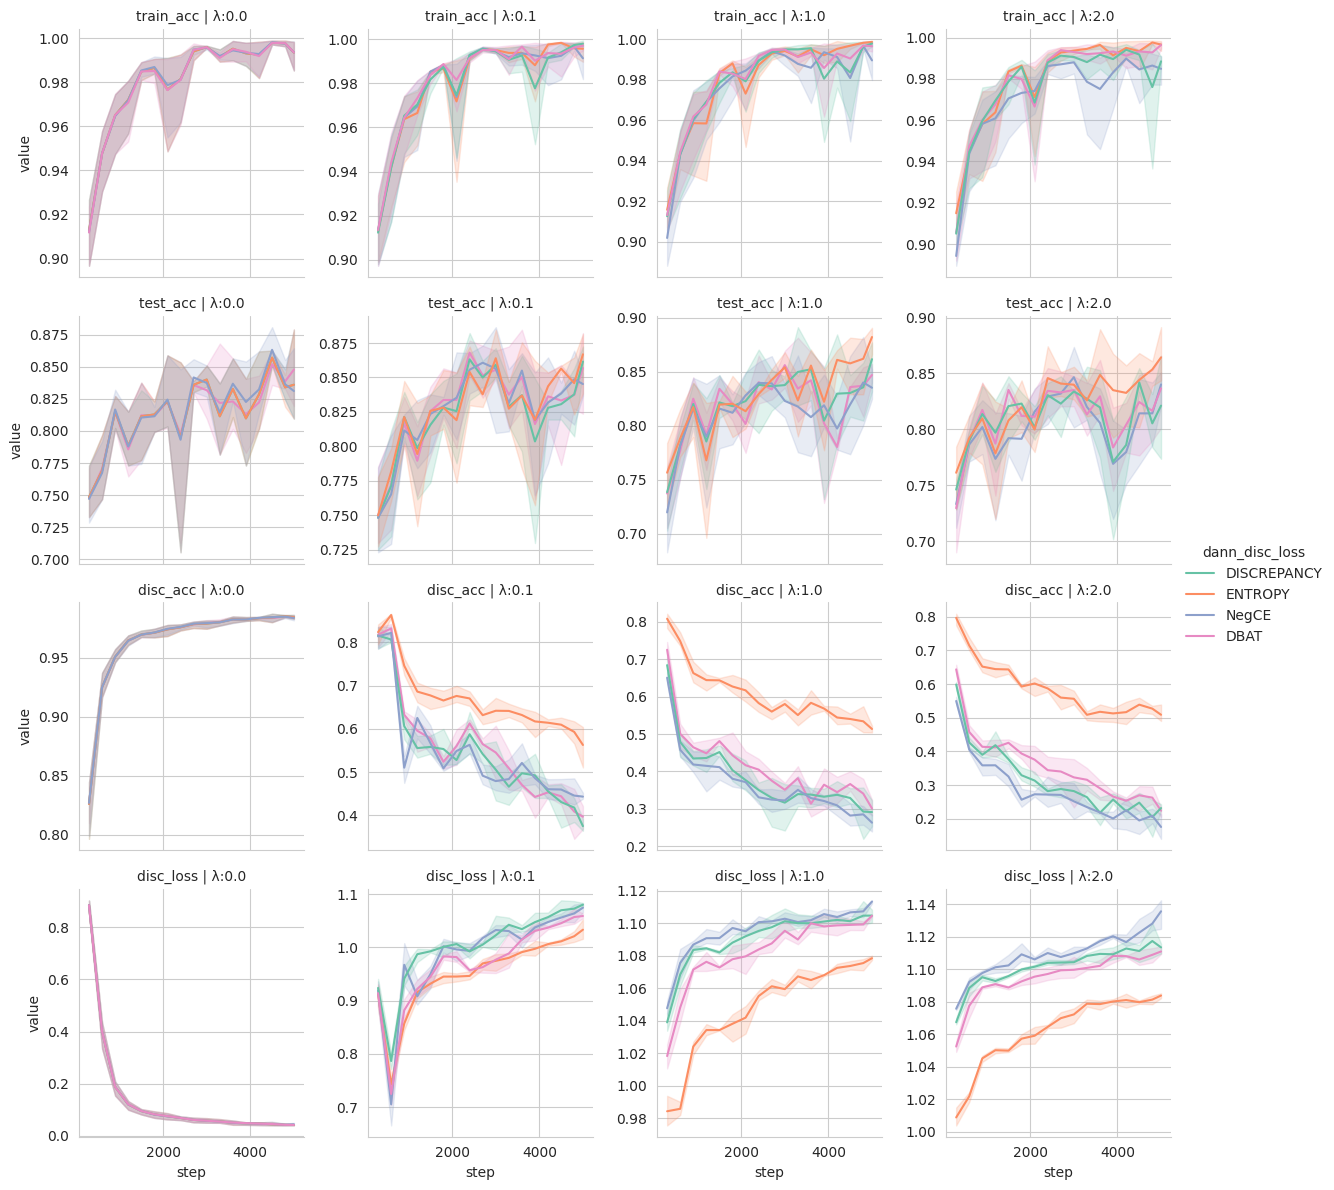

In [17]:
plot_facet_grid(baseline_df, hue='dann_disc_loss', y='value', row='metric', col='dann_lambda', melt_metrics=base_metrics)

### Probing different lambda for discrepancy loss

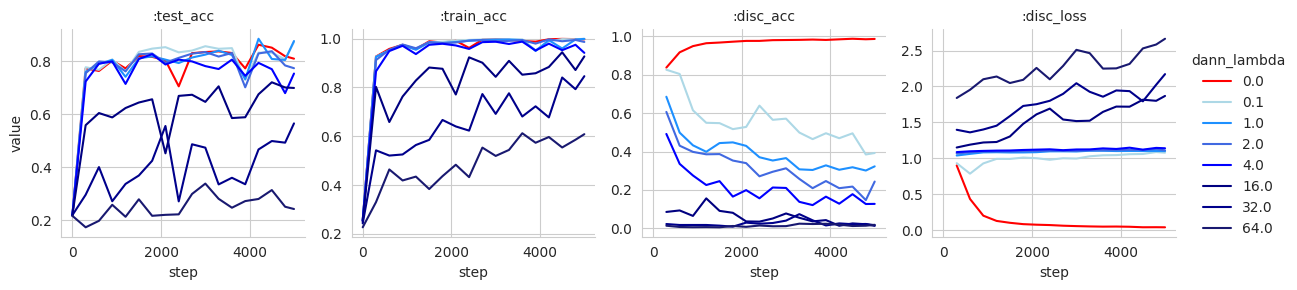

In [18]:
lambda_probe_df = df[df['tags'].str.contains('pac_lambda_probe')]
m = ['test_acc', 'train_acc', 'disc_acc', 'disc_loss']
plot_facet_grid(lambda_probe_df, hue='dann_lambda', y='value', col='metric', melt_metrics=m)

### Discrepancy vs Entropy Loss

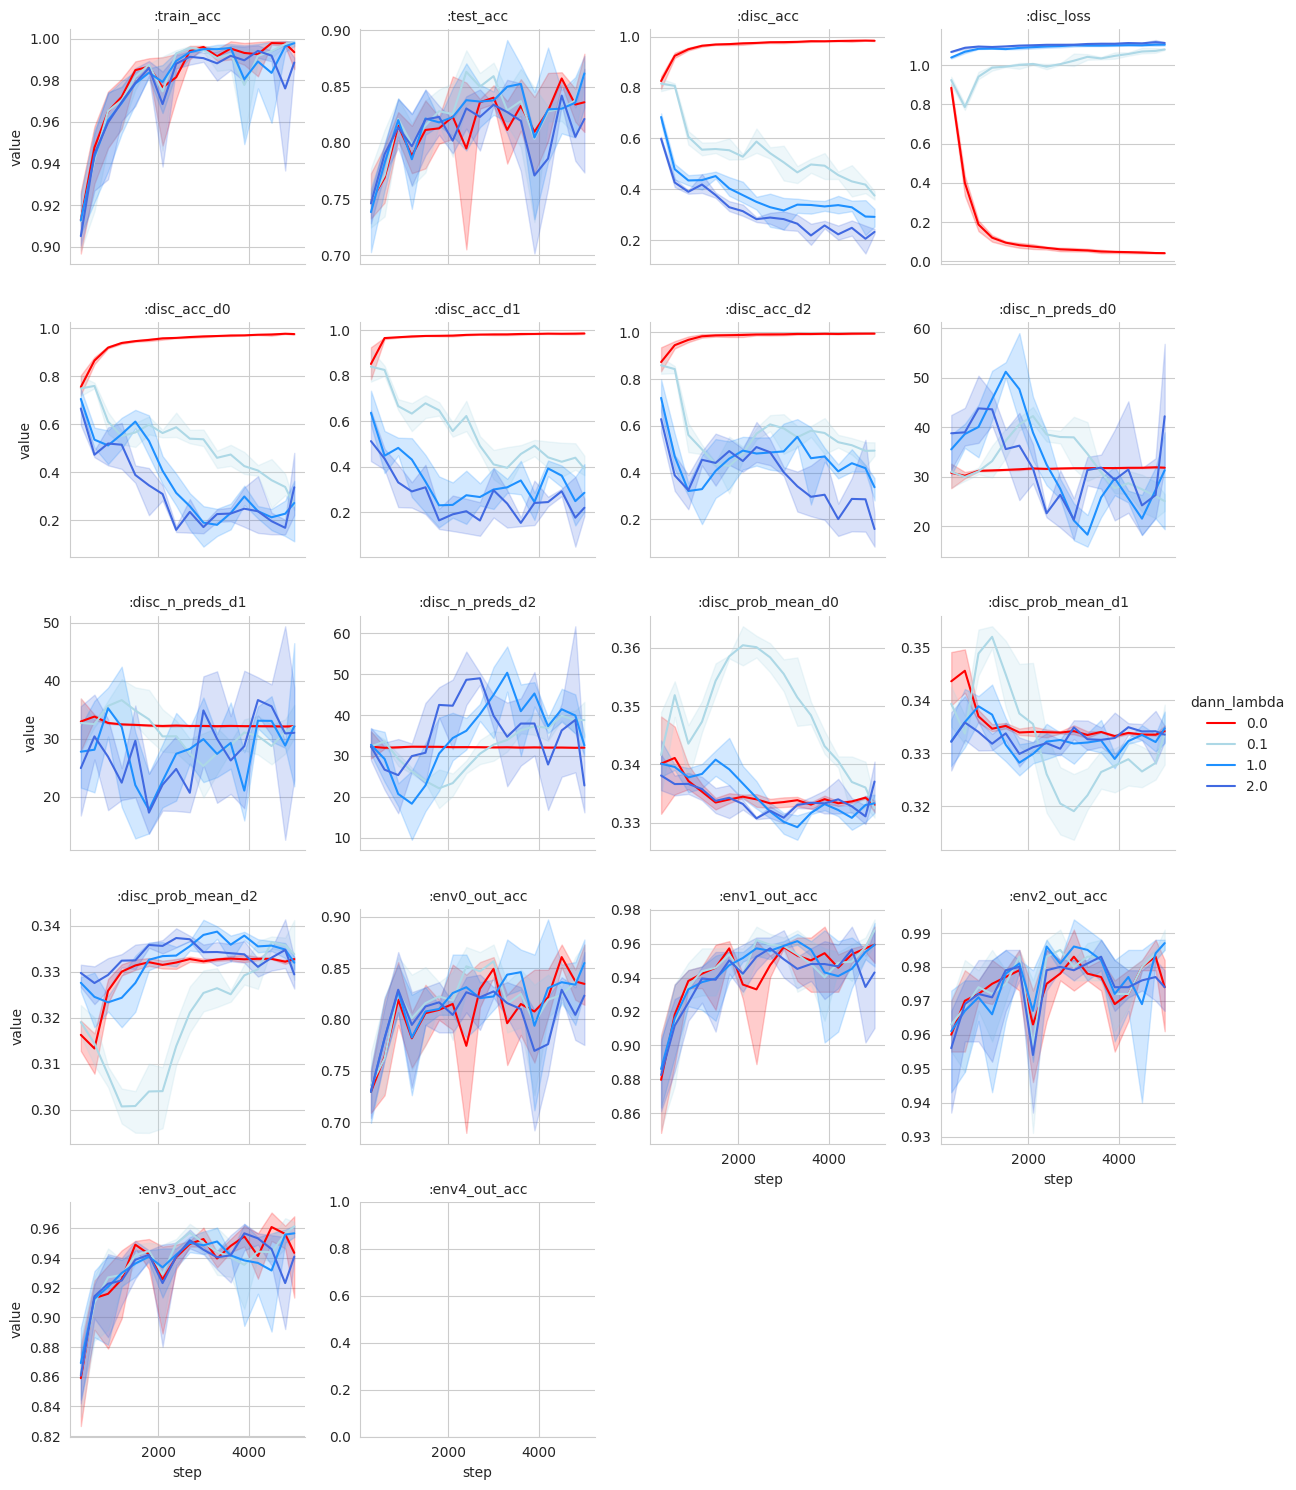

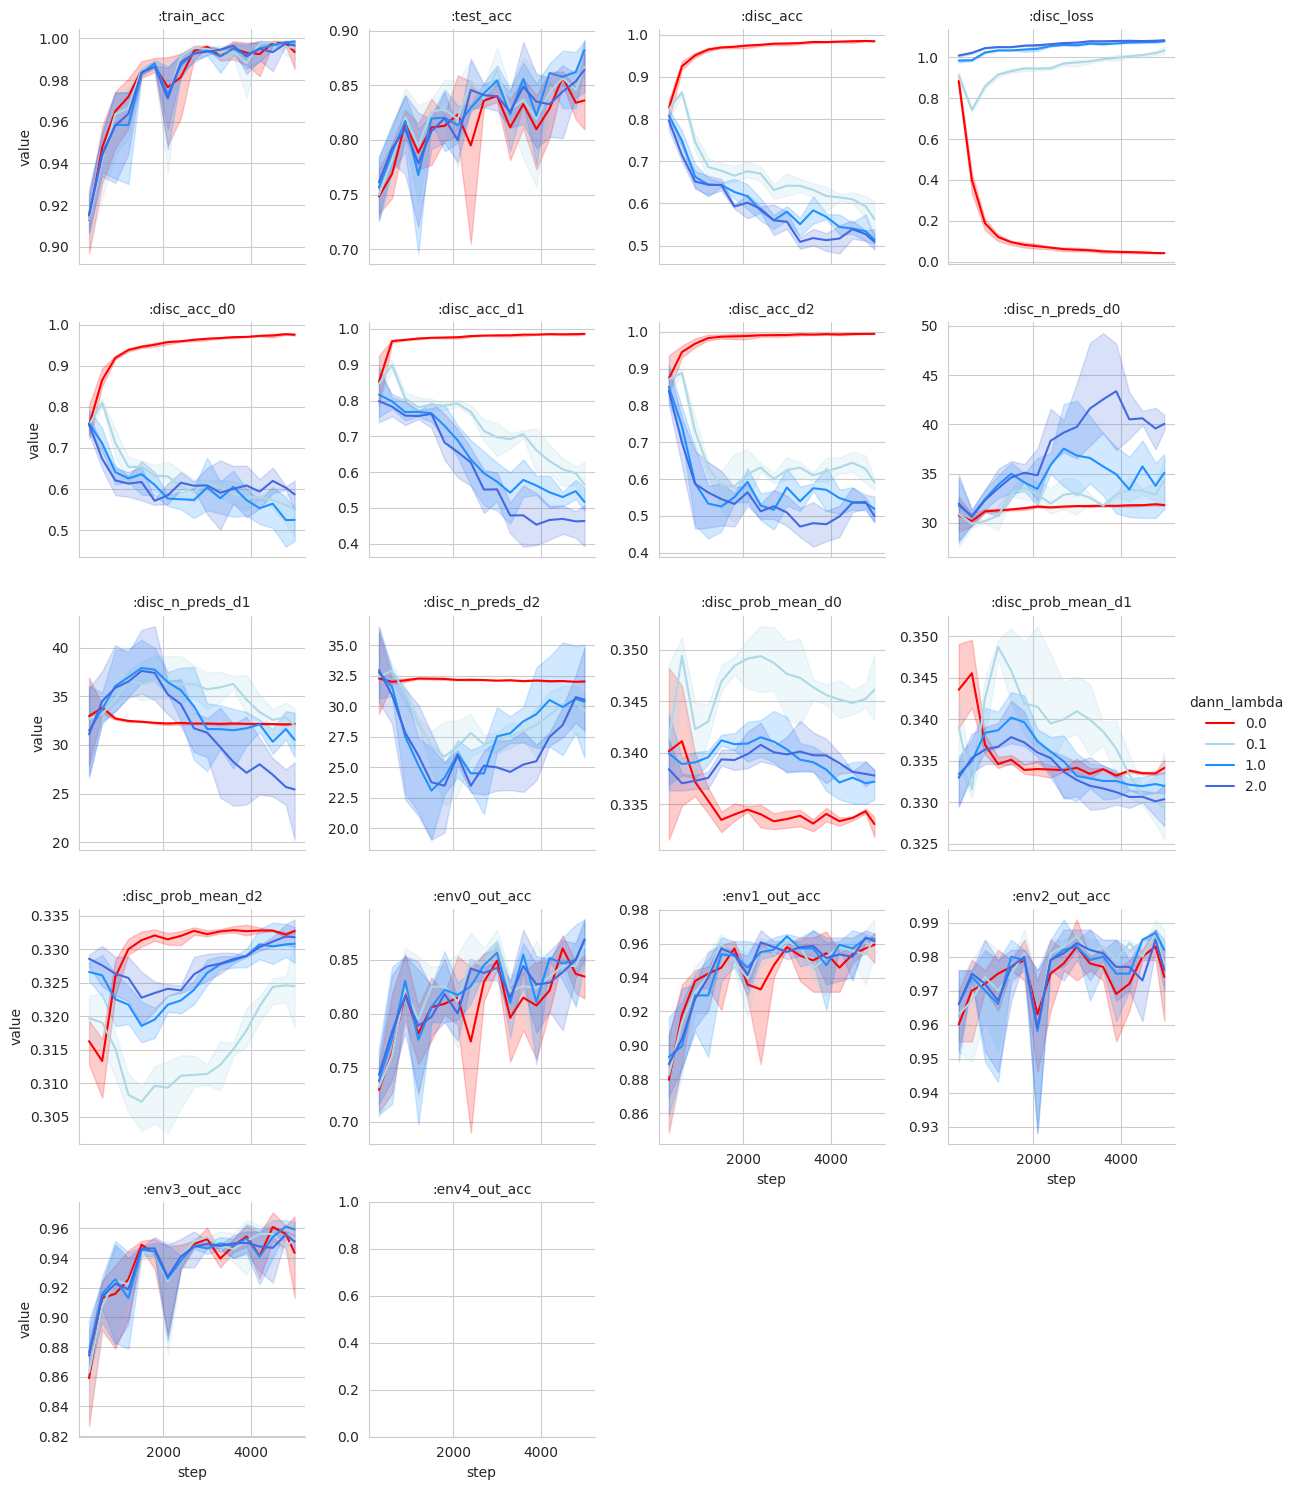

In [19]:
disc_ent_df = baseline_df[baseline_df['dann_disc_loss'].isin(['DISCREPANCY', 'ENTROPY'])]
for loss in ['DISCREPANCY', 'ENTROPY']:
    plot_facet_grid(disc_ent_df.query(f'dann_disc_loss=="{loss}"'), hue='dann_lambda', y='value', col='metric', melt_metrics=base_metrics + add_metrics, col_wrap=4)

### Adding WGAN-GP

In [20]:
grad_pen_df = df[df['tags'].str.contains('pac_gp')]
grad_pen_df.query('step==5000').groupby(['dann_disc_loss', 'grad_penalty', 'dann_lambda'])[['test_acc', 'train_acc']].agg(['mean', 'std']).style.format_index(precision=2).format(precision=2)

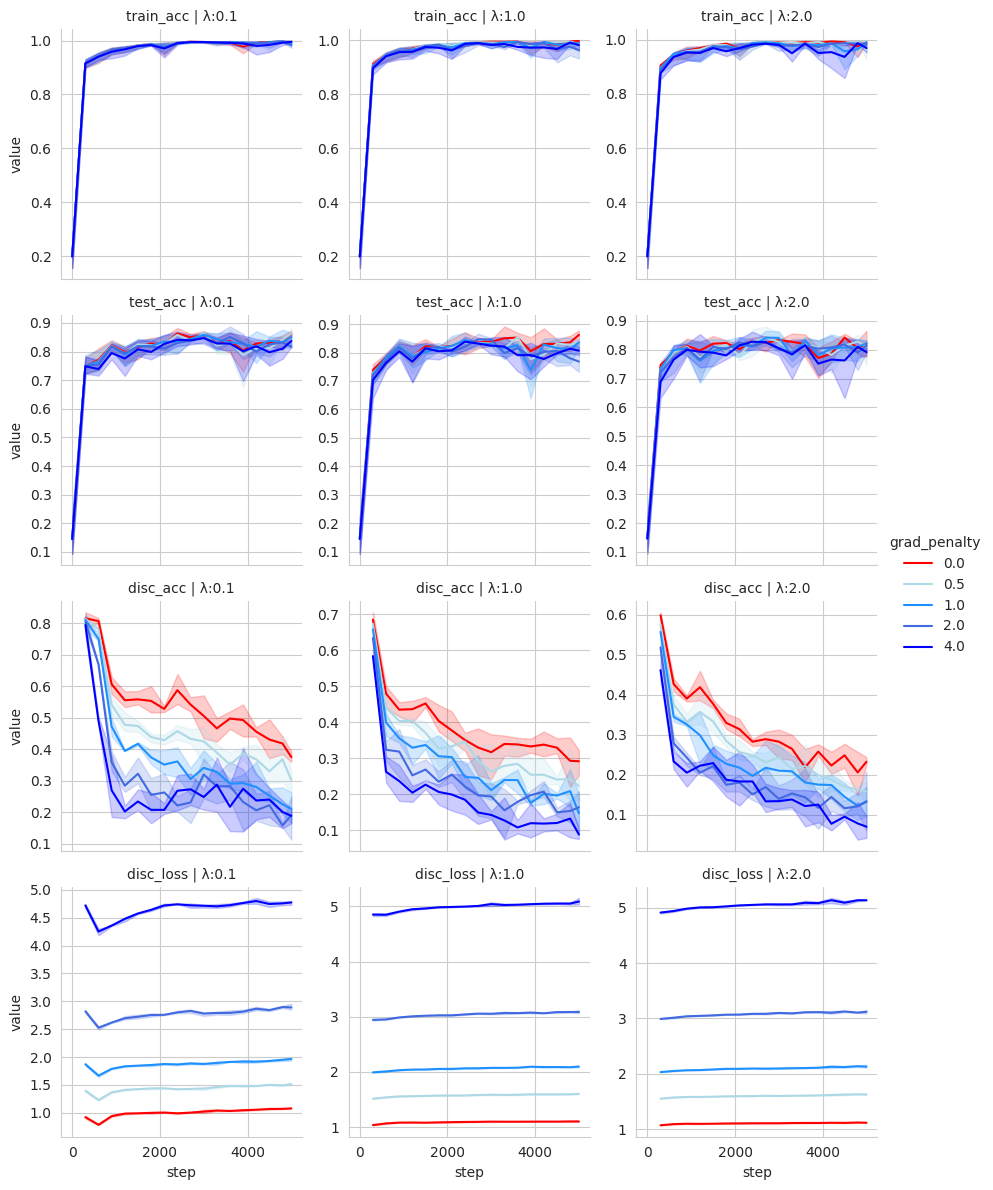

In [21]:
plot_facet_grid(
    grad_pen_df.query('dann_disc_loss=="DISCREPANCY"'), 
    hue='grad_penalty', 
    y='value', 
    row='metric', 
    col='dann_lambda', 
    melt_metrics=base_metrics, 
    )

### Scaling discriminator architecture

In [23]:
arch_df = df[df['tags'].str.contains('pac_arch')]
arch_df.query('step==5000').groupby(['mlp_depth', 'mlp_width', 'grad_penalty', 'dann_lambda'])[['test_acc', 'train_acc']].mean().reset_index().sort_values('test_acc', ascending=False).head(10).reset_index(drop=True).style.format(precision=2)

,mlp_depth,mlp_width,grad_penalty,dann_lambda,test_acc,train_acc
0,4,256,1.00,0.10,0.87,1.00
1,4,512,0.00,0.10,0.87,1.00
2,6,64,0.00,0.10,0.87,1.00
3,4,256,0.00,0.10,0.87,1.00
4,6,64,1.00,0.10,0.87,1.00
5,6,64,1.00,1.00,0.86,1.00
6,4,512,1.00,0.10,0.86,1.00
7,2,64,0.00,0.10,0.86,1.00
8,6,64,0.00,1.00,0.86,1.00
9,6,256,1.00,1.00,0.85,1.00


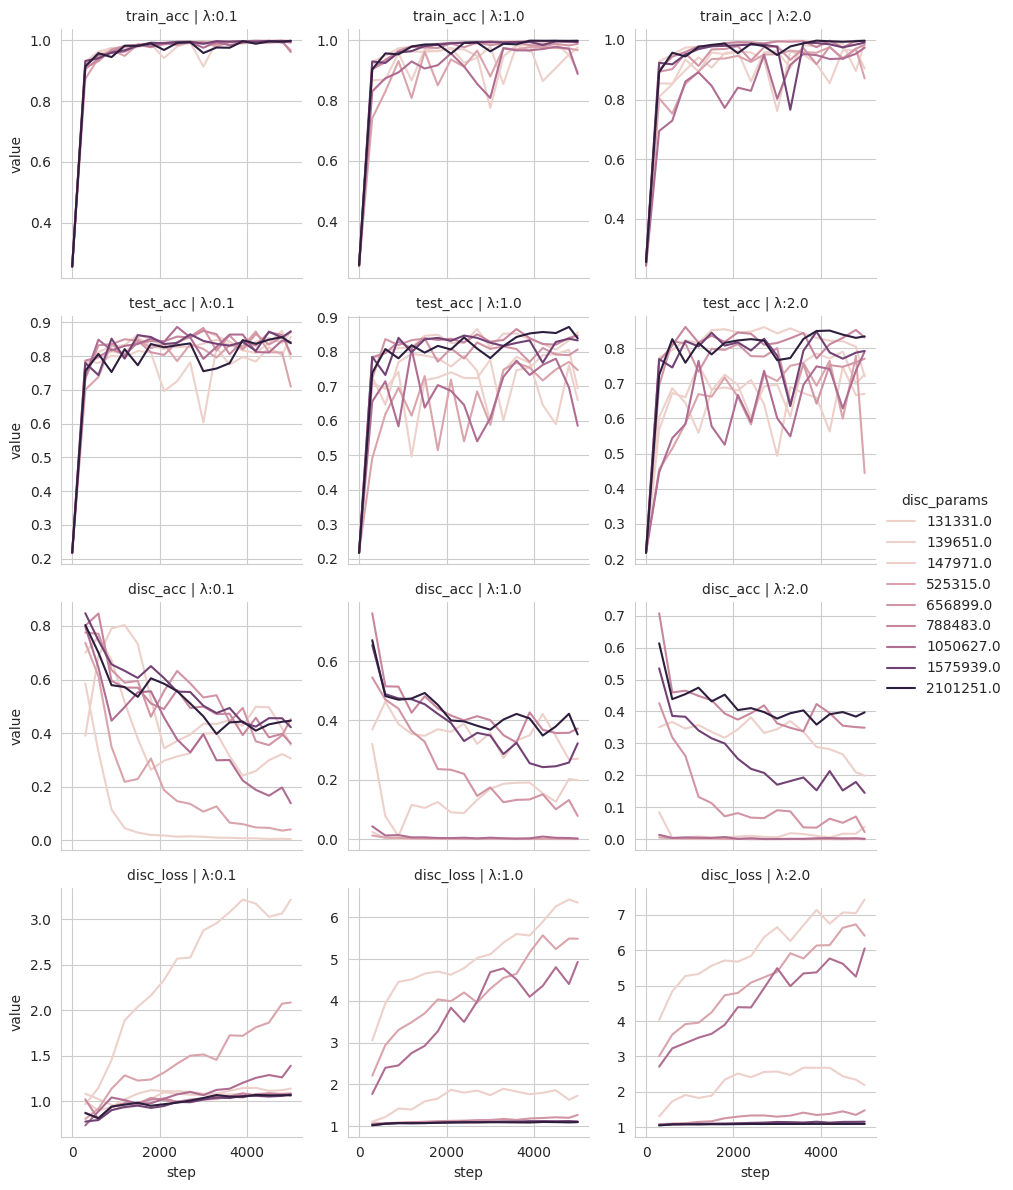

In [26]:
plot_facet_grid(arch_df.query('grad_penalty==0'), hue='disc_params', y='value', row='metric', col='dann_lambda', melt_metrics=base_metrics, palette=None)

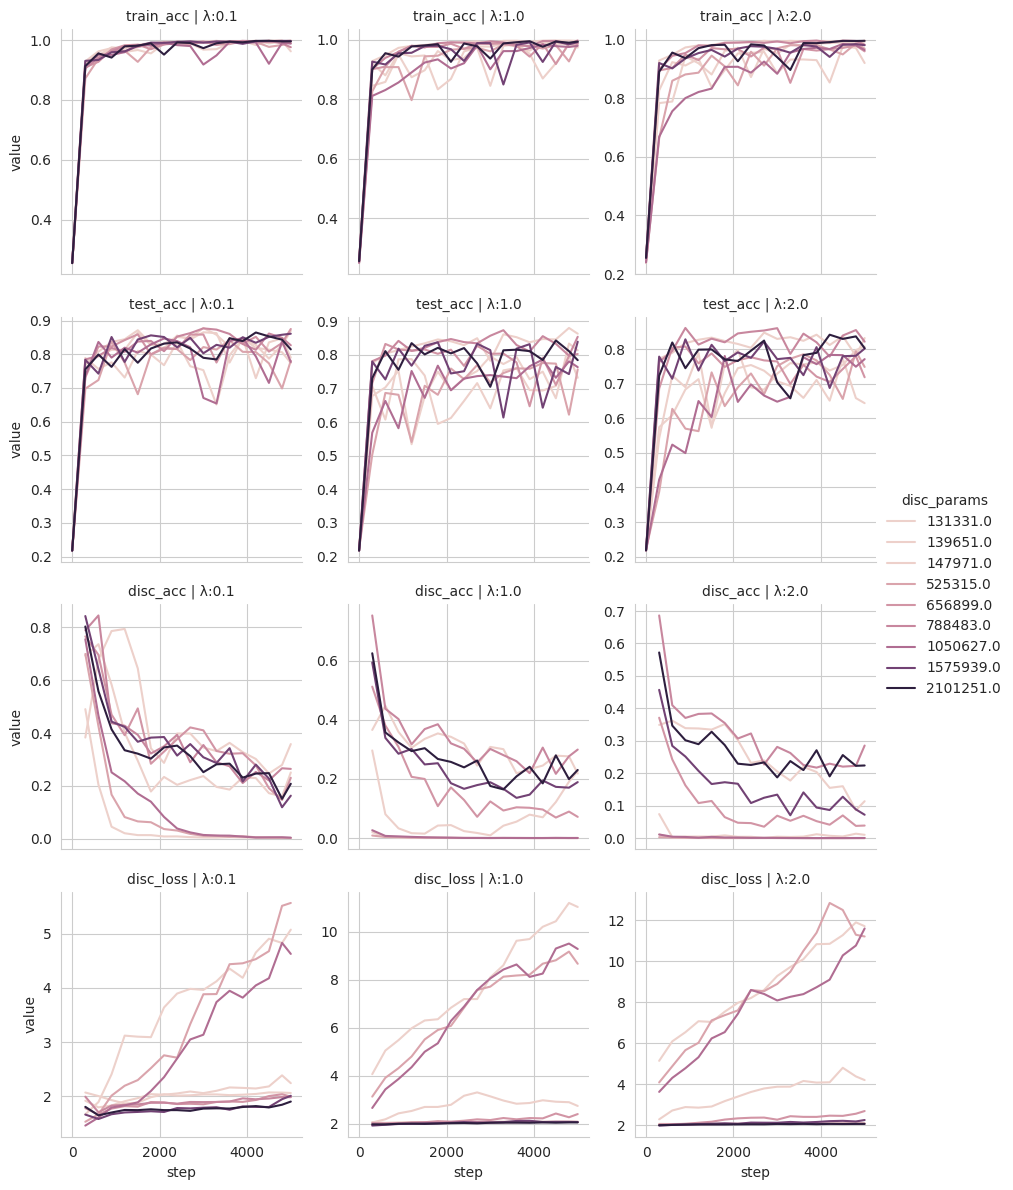

In [27]:
plot_facet_grid(arch_df.query('grad_penalty==1'), hue='disc_params', y='value', row='metric', col='dann_lambda', melt_metrics=base_metrics, palette=None)        